In [67]:
import psutil
import os

import numpy as np
import pandas as pd

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1. Memory usage

In [2]:
def memory_footprint():
    '''Return memory in MB being used by python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return mem / (1024 ** 2)

def memory_used(f):
    def warpper(*args, **kwargs):
        before = memory_footprint()
        result = f(*args, **kwargs)
        after = memory_footprint()
        print(f'Memory used by function {f.__name__}(): {round(after - before)} MB')
        return result
    return warpper

@memory_used
def a():
    N = (1024 ** 2) // 8
    x = np.random.randn(N * 50)
    return x

# use decorated function to calculate memory used
x = a()

# use numpy array.nbytes to calcualte
np_mem = x.nbytes // (1024 ** 2)
print(f'Numpy array memory: {np_mem} MB')

# use pandas memory usage to calculate

pd_mem = pd.DataFrame(x).memory_usage(index = False).sum() // (1024 ** 2)
print(f'Pandas dataframe memory: {pd_mem} MB')

Memory used by function a(): 50 MB
Numpy array memory: 50 MB
Pandas dataframe memory: 50 MB


### 2. Data in chunks

In [3]:
for chunk in pd.read_csv('data/WDI.csv', chunksize=30000):
    print(type(chunk), chunk.shape)

<class 'pandas.core.frame.DataFrame'> (30000, 7)
<class 'pandas.core.frame.DataFrame'> (30000, 7)
<class 'pandas.core.frame.DataFrame'> (30000, 7)
<class 'pandas.core.frame.DataFrame'> (1048, 7)


**Chunk with pandas**

Each chunk is actually a dataframe, so you can do dataframe operations on it

In [4]:
def filter_countries(df, country_codes =  None):
    ''' A simple row filter'''
    if country_codes is None:
        country_codes= ['IDN', 'JPN', 'PHL', 'KOR', 'THA', 
                        'VNM', 'CHN', 'MMR', 'MYS', 'KHM']
        
    country_filter = df['Country Code'].isin(country_codes)
    return df.loc[country_filter]

chunks = []
for chunk in pd.read_csv('data/WDI.csv', chunksize=30000):
    # Use row filter in each trunk of data
    chunks.append(filter_countries(chunk))

# concat truncs into dataframe
wdi = pd.concat(chunks, sort = False)

# or write as
chunks = [filter_countries(chunk) 
     for chunk in pd.read_csv('data/WDI.csv', chunksize = 1000)]
wdi = pd.concat(chunks, sort = False)

**Generator**

In [5]:
# generator 1
chunks = (chunk for chunk in pd.read_csv('data/WDI.csv', usecols = ['Year'], chunksize = 1000))

# generator 2 -> aggregation[looped]
last_year = max(chunk.Year.max() for chunk in chunks)


总要有一个东西去consume generator， 这个就是sum function

In [6]:
def count_long_trips(df):
    long_trip_filter = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds > 1200
    result_dict  = {'n_long': [long_trip_filter.sum()], 'total':[len(df)]}
    return pd.DataFrame(result_dict)

datetime_cols = ['tpep_pickup_datetime','tpep_dropoff_datetime']
filenames = [f'data/nyctaxi/yellow_tripdata_2015-0{i}.csv' for i in range(1,4)]
filereader = (pd.read_csv(f, parse_dates = datetime_cols) for f in filenames)
long_trip_counter = (count_long_trips(df) for df in filereader)

pd.concat(long_trip_counter) # sum(long_trip_counter)

,n_long,total
0,11958,79673
0,11550,61259
0,11813,60592


In [7]:
def percent_delayed(df):
    return round(100 * (df['DEP_DELAY'] > 0).mean(),3)

In [8]:
path = 'data/flightdelays/flightdelays-2016-{}.csv'

months = np.arange(1,6)

filereader = (pd.read_csv(path.format(i)) for i in months)
pct_delay = [percent_delayed(df) for df in filereader]

### Dask delayed

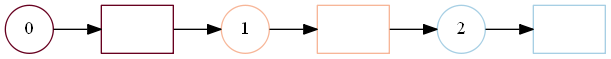

In [9]:
from dask import delayed
from math import sqrt

@delayed
def f(z):
    return sqrt(z + 4)

@delayed
def g(y):
    return y - 3

@delayed
def h(x):
    return x ** 2

w = f(g(h(4)))

w.visualize(rankdir = 'LR', color = 'order')

Result: 50


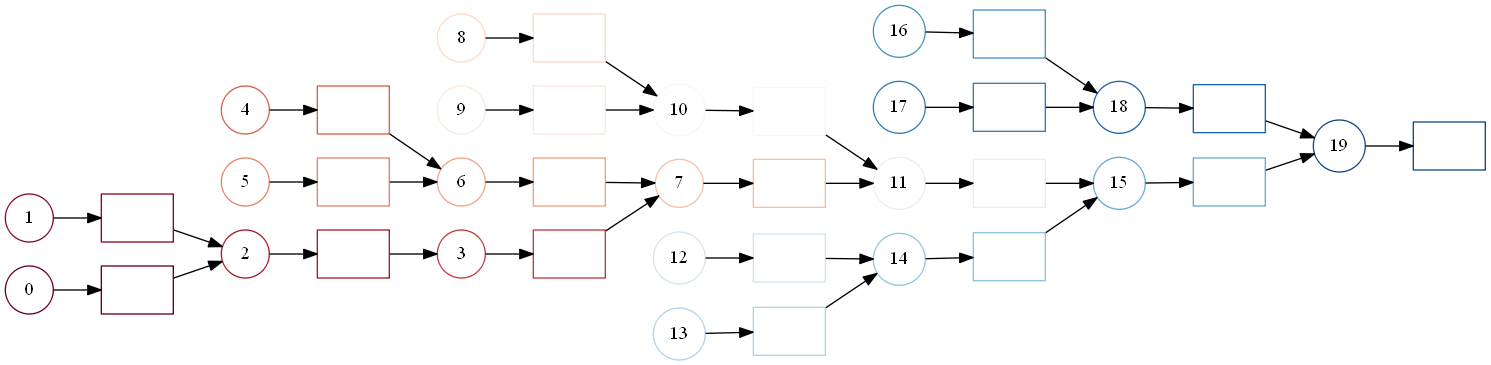

In [10]:
@delayed
def increment(x):
    return x + 1

@delayed
def double(x):
    return x * 2

@delayed
def added(x,y):
    return x + y


data = [1,2,3,4,5]

# the map function
totals = []
for d in data:
    inc = increment(d)
    dou = double(d)
    tot = added(inc, dou)
    totals.append(tot)

# the reduced function
totals = sum(totals)

# compute values happens
result = totals.compute()
print('Result: {}'.format(result))

totals.visualize(rankdir = 'LR', color = 'order')

### Taxi trips data using dask

Computation result:
   n_long   total
0   35321  201524

Type of totals variable: <class 'list'>

Type of elements inside totals:
Delayed('count_long_trips-3c4825c4-b207-49eb-b840-d5c5a4093761')
Delayed('count_long_trips-ea134986-dad6-4d45-89e0-03256a044b5f')
Delayed('count_long_trips-42648751-d509-4f8f-9ff2-857f75301d3e')

All totals: Delayed('add-3f24bcbd07e4ab857fe632dd5311541c')


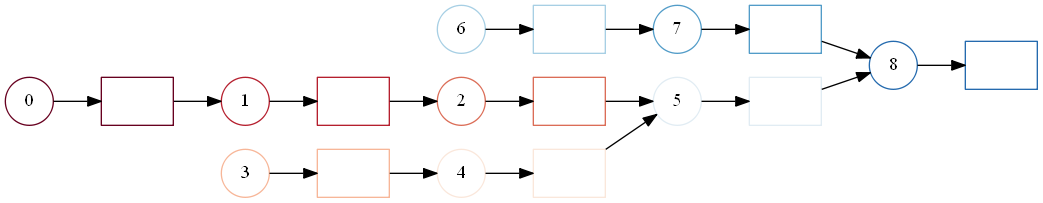

In [11]:
@delayed
def count_long_trips(df):
    '''work on dataframe'''
    long_trip_filter = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds > 1200
    result_dict  = {'n_long': [long_trip_filter.sum()], 'total':[len(df)]}
    return pd.DataFrame(result_dict)

datetime_cols = ['tpep_pickup_datetime','tpep_dropoff_datetime']
filenames = [f'data/nyctaxi/yellow_tripdata_2015-0{i}.csv' for i in range(1,4)]

@delayed
def read_files(f):
    '''work on dataframe'''
    return pd.read_csv(f, parse_dates = datetime_cols)

totals = [count_long_trips(read_files(file)) for file in filenames]

all_totals = sum(totals)

result = all_totals.compute()

print('Computation result:')
print(result)
print(f'\nType of totals variable: {type(totals)}')
print(f'\nType of elements inside totals:')
_ = [print(ele) for ele in totals]
print(f'\nAll totals: {all_totals}')

all_totals.visualize(rankdir = 'LR', color ='order')

### Dask array

In [12]:
import dask.array as da

In [13]:
a =np.random.rand(10000)
a.dtype, a.shape

(dtype('float64'), (10000,))

In [14]:
a_dask = da.from_array(a,chunks = len(a) // 5)

Numpy computation in chunks

In [15]:
n_chunks = 4
chunk_size = len(a) // n_chunks
result = 0
for n in range(n_chunks):
    result += a[n * chunk_size: (n+1) * chunk_size].sum()

Dask array sum

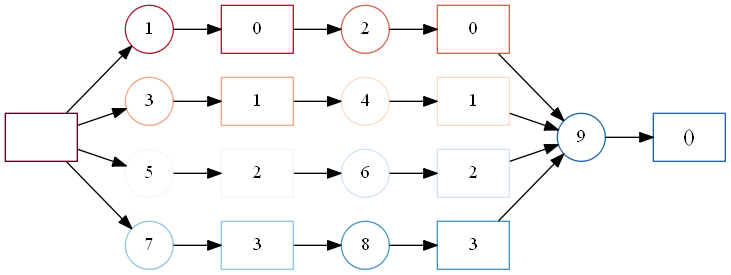

In [23]:
dask_result = da.from_array(a, chunks = len(a) // n_chunks).sum()
dask_result.compute()
dask_result.visualize(rankdir = 'LR', color = 'order')

In [24]:
import h5py, time

In [55]:
with h5py.File('data/Texas/texas.2000.hdf5' ,'r') as dset:
    dist = dset['load'][:]
    
dist_dask8 = da.from_array(dist, chunks = dist.shape[0] // 8)
t_start = time.time();dist_dask8.mean().compute();t_end = time.time()
time_milliseconds = (t_end - t_start) * 1000
print(f'Taking {round(time_milliseconds,3)} milliseconds.')

Taking 3.989 milliseconds.


In [58]:
t_start = time.time();dist.mean();t_end = time.time()
time_milliseconds = (t_end - t_start) * 1000
print(f'Taking {round(time_milliseconds,3)} milliseconds.')

Taking 0.0 milliseconds.


**Dask multidimensional array**

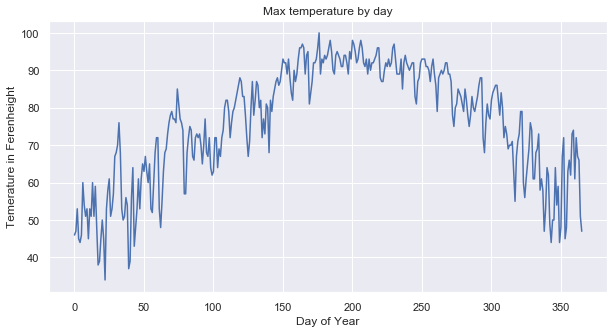

In [72]:

max_temperatures = pd.read_csv('data/weatherdata/ATL.csv')['Max TemperatureF'].values

figsize(10,5)
plt.plot(max_temperatures)
plt.title('Max temperature by day')
plt.xlabel('Day of Year')
plt.ylabel('Temerature in Ferenheight')
plt.show()

**Numpy reshape with order option**

In [78]:
arr = np.arange(1,22)
arr.reshape((7,3), order = 'C')

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [13, 14, 15],
       [16, 17, 18],
       [19, 20, 21]])

In [77]:
arr.reshape((7,3), order = 'F')

array([[ 1,  8, 15],
       [ 2,  9, 16],
       [ 3, 10, 17],
       [ 4, 11, 18],
       [ 5, 12, 19],
       [ 6, 13, 20],
       [ 7, 14, 21]])

In [79]:
arr.reshape((7,3))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [13, 14, 15],
       [16, 17, 18],
       [19, 20, 21]])

In [98]:
# temperature data form 3 weeks
time_series = max_temperatures[:21]

# reshape with order  = 'F'
table = time_series.reshape(7,3, order = 'F')

# visualize the meaning of data
pd.DataFrame(table,columns = ['week1','week2','week3'],
             index = ['Mon','Tue',"Wed",'Thu','Fri','Sat','Sun'])

,week1,week2,week3
Mon,46,54,51
Tue,47,51,59
Wed,53,53,48
Thu,45,45,38
Fri,44,53,39
Sat,46,51,45
Sum,60,60,50


In [103]:
# reshape with order  = 'C'
table = time_series.reshape(3,7, order = 'C')
table

array([[46, 47, 53, 45, 44, 46, 60],
       [54, 51, 53, 45, 53, 51, 60],
       [51, 59, 48, 38, 39, 45, 50]], dtype=int64)

In [108]:
table.mean()
table.mean(axis = 0)
table.mean(axis = 1)
table.mean(axis = (0,1))

49.42857142857143

In [111]:
daily_means = table.mean(axis = 0)
week_means = table.mean(axis = 1)

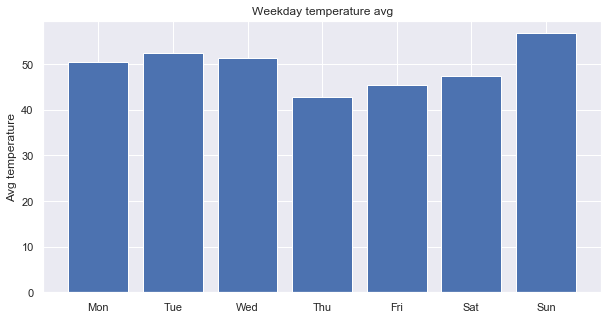

In [119]:
plt.bar(x = np.arange(1,8), height = daily_means)
plt.xticks(ticks = np.arange(1,8), labels = ['Mon','Tue',"Wed",'Thu','Fri','Sat','Sun'])
plt.ylabel('Avg temperature')
plt.title('Weekday temperature avg')
plt.show()